In [1]:
import pymc
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns


from pymc import HalfCauchy, Model, Normal, sample

In [2]:
df = pd.read_csv("football.csv", delimiter=";")

In [3]:
test = df.loc[df["GoalsScored"].isna()]
train = df.loc[df["GoalsScored"].notna()]

X_train = train.drop(columns="GoalsScored").to_numpy()
y_train = train["GoalsScored"].to_numpy()

X_test = test.drop(columns="GoalsScored").to_numpy()
y_test = test["GoalsScored"].to_numpy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = np.column_stack((X_train, np.ones(X_train.shape[0])))

In [4]:
names = [col[2:] for col in df.columns if col != "GoalsScored"]
names.append("Intercept")

with pm.Model(coords={"b": names}) as poisson_model:

    # b_0 = Normal("b_0", 0, sigma=5)
    b = Normal("b_", 0, sigma=10, shape=X_train.shape[1], dims=["b"])
    lambda_ = pm.math.exp(pm.math.dot(X_train, b))

    y_obs = pm.Poisson("y_obs", mu=lambda_, observed=y_train)

    idata = sample(3000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
c:\Users\matej\miniconda3\envs\MLDS_HW1\Lib\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_]


c:\Users\matej\miniconda3\envs\MLDS_HW1\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 84 seconds.


Perhaps using this to better show the uncertainty of the beta parameters since the distributions aren't very legible. NORMAL VERSION

[Text(0, 0.0, 'FoulRatioA'),
 Text(0, 0.825, 'FoulRatioH'),
 Text(0, 1.65, 'CornerRatioA'),
 Text(0, 2.4749999999999996, 'CornerRatioH'),
 Text(0, 3.3, 'ConcedeRateA'),
 Text(0, 4.125, 'ConcedeRateH'),
 Text(0, 4.95, 'ScoreRateA'),
 Text(0, 5.775, 'ScoreRateH')]

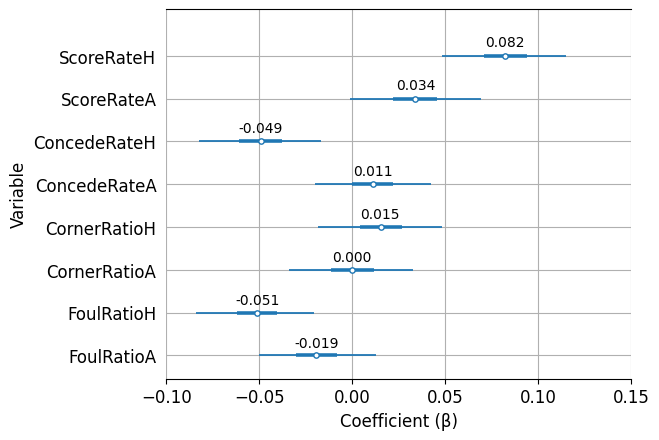

In [5]:
import arviz.labels as azl

excluded_names = [n for n in names if n != "Intercept"]
labeller = azl.MapLabeller(var_name_map={"b_": ""})

summary = az.summary(idata, hdi_prob=0.95)

# Drop intercept row by name or index (assuming it's last)
summary_trimmed = summary.iloc[:-1]

ax = az.plot_forest(
    idata,
    var_names=["b_"],
    combined=True,
    coords={"b": excluded_names},
    hdi_prob=0.95,
    labeller=labeller,
    textsize=12,
)
means = summary_trimmed["mean"].values
y_pos = np.arange(len(means))

for i, mean in enumerate(reversed(means)):
    ax[0].text(mean, 0.1 + i + (-i*0.17), f"{mean:.3f}", ha='center', va='bottom', fontsize=10, color='black')


ax[0].grid(True, axis='both')
ax[0].set_ylabel("Variable", size=12)
ax[0].set_title(None)
# ax[0].set_xlim(-0.1, 0.15)

# Set ticks at intervals of 0.05 within that range
ticks = np.arange(-0.1, 0.16, 0.05)
ax[0].set_xticks(ticks)
ax[0].set_xlabel("Coefficient (β)", size=12)

labels = [label.get_text().strip('[]') for label in ax[0].get_yticklabels()]

# Set the cleaned labels
ax[0].set_yticklabels(labels)

Perhaps using this to better show the uncertainty of the beta parameters since the distributions aren't very legible. EXPONENTIATED VERSION

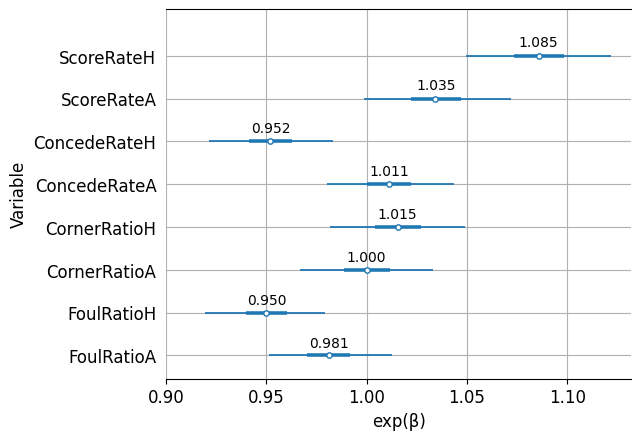

In [6]:
import arviz.labels as azl

excluded_names = [n for n in names if n != "Intercept"]
labeller = azl.MapLabeller(var_name_map={"b_": ""})

summary = az.summary(idata, hdi_prob=0.95)

# Drop intercept row by name or index (assuming it's last)
summary_trimmed = summary.iloc[:-1]

ax = az.plot_forest(
    idata,
    var_names=["b_"],
    combined=True,
    coords={"b": excluded_names},
    hdi_prob=0.95,
    labeller=labeller,
    textsize=12,
    transform=np.exp
)
means = summary_trimmed["mean"].values
y_pos = np.arange(len(means))

for i, mean in enumerate(reversed(means)):
    ax[0].text(np.exp(mean), 0.1 + i + (-i*0.17), f"{np.exp(mean):.3f}", ha='center', va='bottom', fontsize=10, color='black')


ax[0].grid(True, axis='both')
ax[0].set_ylabel("Variable", size=12)
ax[0].set_title(None)
# # ax[0].set_xlim(-0.1, 0.15)

# # Set ticks at intervals of 0.05 within that range
ticks = np.arange(0.9, 1.125, 0.05)
ax[0].set_xticks(ticks)
ax[0].set_xlabel("exp(β)", size=12)
labels = [label.get_text().strip('[]') for label in ax[0].get_yticklabels()]

# Set the cleaned labels
ax[0].set_yticklabels(labels)
plt.savefig("Betas.pdf", bbox_inches="tight")

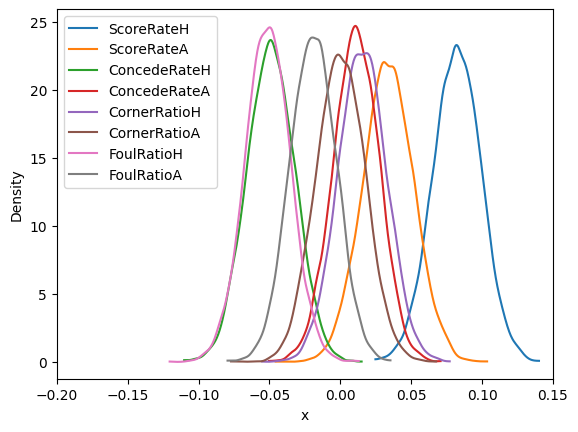

In [7]:
plt.rcParams.update({
    "font.size": 11,        # Base font size
    "axes.titlesize": 12,   # Title font size
    "axes.labelsize": 10,   # Axis label font size
    "xtick.labelsize": 10,   # X tick labels
    "ytick.labelsize": 10,   # Y tick labels
    "legend.fontsize": 10    # Legend text
})

fig, ax = plt.subplots()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for name, color in zip(excluded_names, colors):
    az.plot_kde(idata.posterior["b_"].sel(b=name).values.flatten(), ax=ax, label=name, plot_kwargs={"color": color})

ax.set_xlim(-0.20, 0.15)
ax.set_ylabel("Density")
ax.set_xlabel("x")
plt.savefig("Distributions.pdf", bbox_inches="tight")

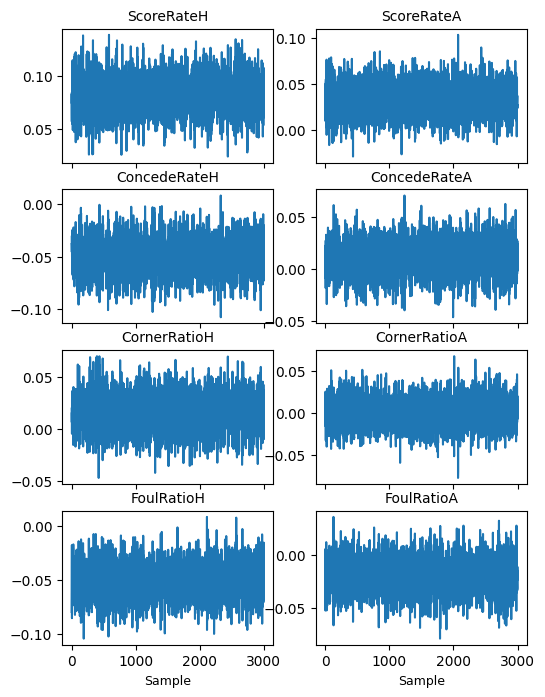

In [8]:
figure, axes = plt.subplots(4, 2, figsize=(6, 8), sharex=True)
num = 1

for i, name in enumerate(excluded_names):
    for k in range(num):
        axes[i // 2][i % 2].plot(idata.posterior["b_"].sel(b=name).values[k])
        axes[i // 2][i % 2].set_title(name, size=10)
axes[3][0].set_xlabel("Sample", size=9)
axes[3][1].set_xlabel("Sample", size=9)
plt.savefig("traceplots.pdf", bbox_inches="tight")

In [9]:
ess_df = az.ess(idata, method="bulk").to_dataframe().reset_index()
ess_df["ess"] = ess_df["b_"] / 4
ess_df

,b,b_,ess
0,ScoreRateH,16005.170403,4001.292601
1,ScoreRateA,17598.125178,4399.531295
2,ConcedeRateH,17972.205088,4493.051272
3,ConcedeRateA,18373.752579,4593.438145
4,CornerRatioH,17839.804217,4459.951054
5,CornerRatioA,17196.079222,4299.019805
6,FoulRatioH,15735.801182,3933.950295
7,FoulRatioA,19532.181857,4883.045464
8,Intercept,18523.929827,4630.982457


# Laplace Approximation

In [10]:
from scipy.optimize import minimize

X_test
betas_0 = np.zeros(X_train.shape[1])
alpha = 10

def neg_log_posterior(betas, X, y, alpha):
    eta = X @ betas
    return np.sum(np.exp(eta) - y * eta) + (1 / (2 * alpha)) * np.sum(betas**2)

# def grad(betas, X, y, alpha):
#     return - X @ y + X @ np.exp(X @ betas) + 1/alpha * betas

def grad(betas, X, y, alpha):
    return X.T @ (np.exp(X @ betas) - y) + (1 / alpha) * betas

# def hessian(betas, X, y, alpha):
#     return - X @ np.diag(np.exp(X @ betas)) @ X + 1/alpha * np.eye(X.shape[0], X.shape[0])

def hessian(betas, X, y, alpha):
    mu = np.exp(X @ betas)
    D = np.diag(mu)
    return X.T @ D @ X + (1 / alpha) * np.eye(X.shape[1])

res = minimize(
    neg_log_posterior,
    betas_0,
    args=(X_train, y_train, alpha),
    method='Newton-CG',  # or 'Newton-CG', 'BFGS', etc.
    jac=grad,
    hess=hessian
)

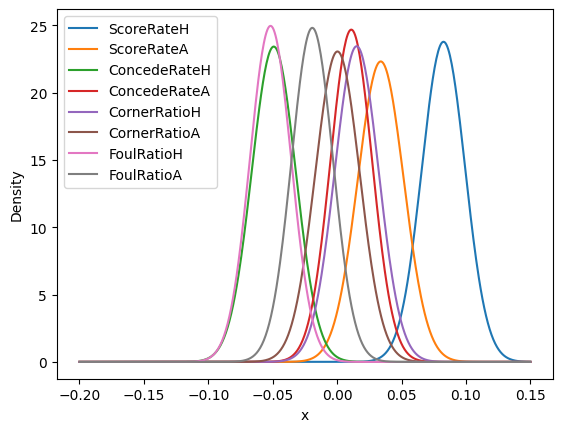

In [11]:
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal, mode
import numpy as np
betas = res.x
plt.rcParams.update({
    "font.size": 11,        # Base font size
    "axes.titlesize": 10,   # Title font size
    "axes.labelsize": 10,   # Axis label font size
    "xtick.labelsize": 10,   # X tick labels
    "ytick.labelsize": 10,   # Y tick labels
    "legend.fontsize": 10    # Legend text
})
hess = hessian(betas, X_train, y_train, alpha)
cov = np.linalg.inv(hess)

x_vals = np.linspace(-0.2, 0.15, 500)  # Adjust range if needed

for i, b in enumerate(betas[:-1]):
    mean = b
    variance = cov[i][i]
    std = np.sqrt(variance)
    y_vals = norm.pdf(x_vals, loc=mean, scale=std)
    plt.plot(x_vals, y_vals, label=excluded_names[i])
plt.ylabel("Density")
plt.xlabel("x")
plt.legend()
plt.savefig("Distributions-Laplace.pdf", bbox_inches="tight")

# Making point predictions

Loss functions

In [12]:
def squared_error(y_pred, y_true):
    return(np.mean((y_pred - y_true)**2))

def absolute_error(y_pred, y_true):
    return(np.mean(np.abs(y_pred - y_true)))

def accuracy(y_pred, y_true):
    correct_counts = 0

    for s in range(y_pred.shape[0]):  # iterate over samples
        sample_pred = np.round(y_pred[s, :])       # shape (N,)
        correct = np.sum(sample_pred == np.round(y_true))
        correct_counts += correct

    accuracy = correct_counts / (y_pred.shape[0] * y_pred.shape[1])
    return accuracy

In [13]:
rv = multivariate_normal(betas, cov)

np.random.seed(42)

M = 1000
beta_matrix = np.random.multivariate_normal(betas, cov, 1000)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = np.column_stack((X_test_scaled, np.ones(X_test_scaled.shape[0])))

predictions = np.exp(beta_matrix @ X_test_scaled.T)

# expanded_lambdas = np.repeat(predictions[:, :, np.newaxis], M, axis=2)
y_samples = np.random.poisson(
    lam=predictions[:, :, np.newaxis],  # shape (1000, 100, 1)
    size=(predictions.shape[0], predictions.shape[1], M)  # shape (1000, 100, 1000)
)

y_samples = np.transpose(y_samples, (0, 2, 1))

y_samples = y_samples.reshape(-1, y_samples.shape[2]) 

predictions_for_MSE = y_samples.mean(axis=0)

predictions_for_MAE = np.median(y_samples, axis=0)

predictions_for_ACC = mode(np.round(y_samples), axis=0, keepdims=False).mode

In [14]:
display(squared_error(y_samples, predictions_for_MSE))
display(absolute_error(y_samples, predictions_for_MAE))
accuracy(y_samples, predictions_for_ACC)

np.float64(2.781051133065024)

np.float64(1.30339029)

np.float64(0.24273086)

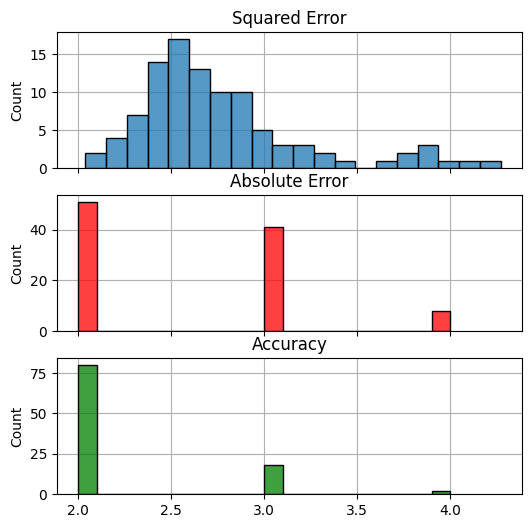

In [52]:
figure, ax = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
sns.histplot(predictions_for_MSE, bins=20, ax=ax[0])
sns.histplot(predictions_for_MAE, bins=20, ax=ax[1], color="red")
sns.histplot(predictions_for_ACC, bins=20, ax=ax[2], color="green")

ax[0].set_title("Squared Error")
ax[1].set_title("Absolute Error")
ax[2].set_title("Accuracy")

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True) 
ax[2].set_axisbelow(True)

plt.savefig("Point_predictions.pdf", bbox_inches="tight")

<Axes: ylabel='Count'>

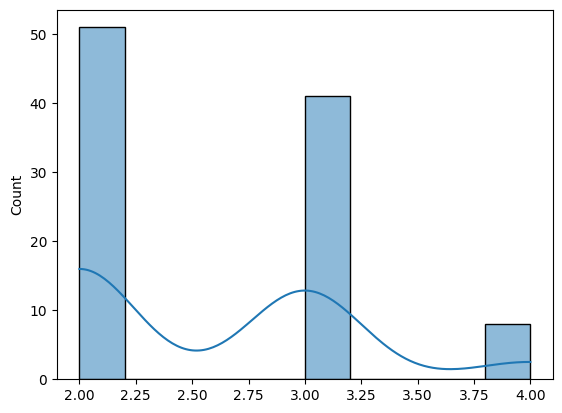

In [16]:
sns.histplot(predictions_for_MAE, kde=True, bins=10)

<Axes: ylabel='Count'>

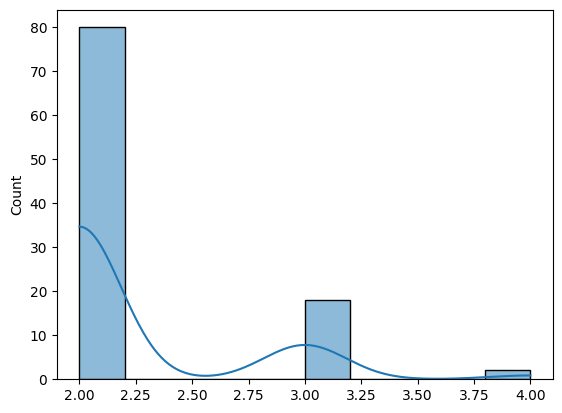

In [17]:
sns.histplot(predictions_for_ACC, kde=True, bins=10)

In [20]:
predictions_for_MAE

array([3., 2., 2., 3., 3., 3., 2., 2., 2., 3., 4., 2., 3., 2., 2., 2., 2.,
       2., 3., 2., 2., 3., 2., 2., 3., 4., 4., 3., 3., 2., 2., 3., 4., 2.,
       3., 2., 3., 2., 2., 2., 3., 3., 2., 2., 4., 3., 2., 2., 2., 2., 2.,
       2., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 3., 3., 2., 2., 2.,
       2., 2., 3., 2., 4., 2., 3., 3., 3., 2., 3., 3., 4., 3., 2., 2., 3.,
       3., 3., 2., 3., 2., 2., 2., 2., 2., 2., 3., 4., 3., 2., 3.])

# Trying the distribution comparison plot

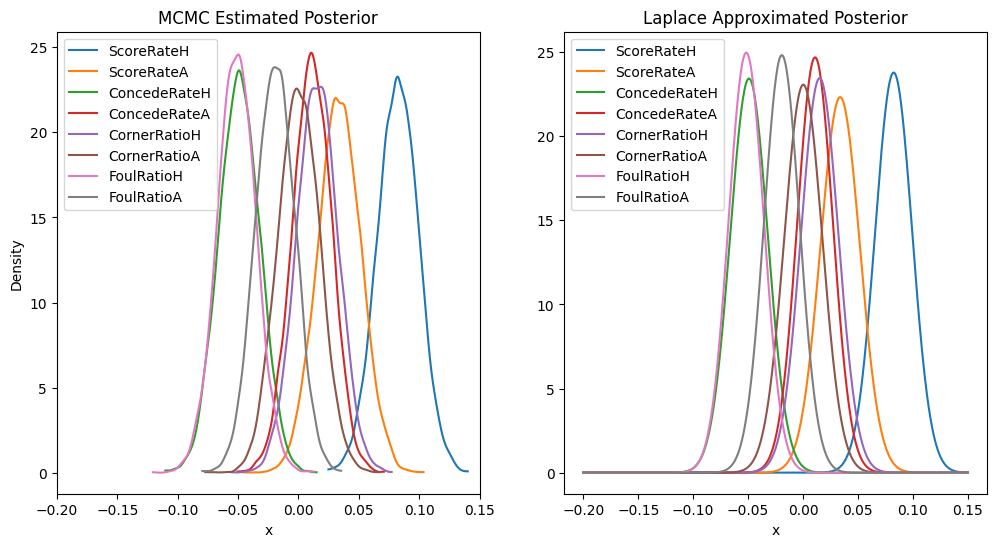

In [18]:
plt.rcParams.update({
    "font.size": 11,        # Base font size
    "axes.titlesize": 12,   # Title font size
    "axes.labelsize": 10,   # Axis label font size
    "xtick.labelsize": 10,   # X tick labels
    "ytick.labelsize": 10,   # Y tick labels
    "legend.fontsize": 10    # Legend text
})

fig, ax = plt.subplots(1,2, figsize=(12,6))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for name, color in zip(excluded_names, colors):
    az.plot_kde(idata.posterior["b_"].sel(b=name).values.flatten(), ax=ax[0], label=name, plot_kwargs={"color": color})

ax[0].set_xlim(-0.20, 0.15)
ax[0].set_ylabel("Density")
ax[0].set_xlabel("x")
ax[0].set_title("MCMC Estimated Posterior")

for i, b in enumerate(betas[:-1]):
    mean = b
    variance = cov[i][i]
    std = np.sqrt(variance)
    y_vals = norm.pdf(x_vals, loc=mean, scale=std)
    ax[1].plot(x_vals, y_vals, label=excluded_names[i])
ax[1].set_xlabel("x")
ax[1].legend()
ax[1].set_title("Laplace Approximated Posterior")

plt.savefig("Combined_Densities.pdf", bbox_inches="tight")